In [99]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout, MaxPooling2D
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, input_shape, output_shape):
        super(MultiSplit, self).__init__()
        self.encoder = self._create_encoder(latent_dim, input_shape)
        self.input_reshaper = utils.Reshaper((n_splits, *input_shape), input_shape)
        self.latent_reshaper = utils.Reshaper([latent_dim], [n_splits * latent_dim])
        self.decoder = self._create_decoder(n_splits * latent_dim, output_shape)
        self.classifier = self._create_classifier(n_splits * latent_dim)
        self.regressor = self._create_regressor(n_splits * latent_dim)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters=[32,64]):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),  #! Reduce amount of neurons by 4.
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='relu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

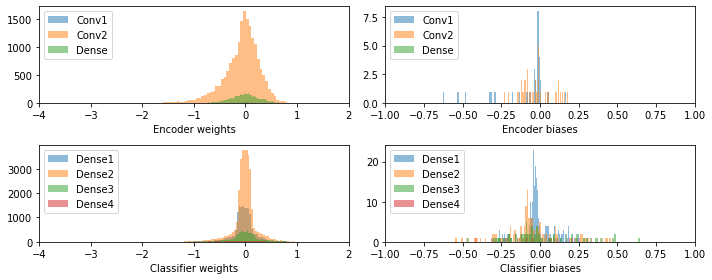

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

model = MultiSplit(16, 4, (14,14,1), (56,56,1))
model.encoder.load_weights('../weights/42_CAE4x16_classif_enc_epoch50_weights.h5')
model.classifier.load_weights('../weights/42_CAE4x16_classif_clas_epoch50_weights.h5')

w1 = model.encoder.layers[0].get_weights()[0].flatten()
b1 = model.encoder.layers[0].get_weights()[1].flatten()

w2 = model.encoder.layers[1].get_weights()[0].flatten()
b2 = model.encoder.layers[1].get_weights()[1].flatten()

w3 = model.encoder.layers[3].get_weights()[0].flatten()
b3 = model.encoder.layers[3].get_weights()[1].flatten()

class_w1 = model.classifier.layers[0].get_weights()[0].flatten()
class_b1 = model.classifier.layers[0].get_weights()[1].flatten()

class_w2 = model.classifier.layers[1].get_weights()[0].flatten()
class_b2 = model.classifier.layers[1].get_weights()[1].flatten()

class_w3 = model.classifier.layers[2].get_weights()[0].flatten()
class_b3 = model.classifier.layers[2].get_weights()[1].flatten()

class_w4 = model.classifier.layers[3].get_weights()[0].flatten()
class_b4 = model.classifier.layers[3].get_weights()[1].flatten()

w_ges = np.concatenate((w1,w2,w3), axis=0)
b_ges = np.concatenate((b1,b2,b3), axis=0)

class_w_ges = np.concatenate((class_w1,class_w2,class_w3, class_w4), axis=0)
class_b_ges = np.concatenate((class_b1,class_b2,class_b3, class_b4), axis=0)

plt.figure(figsize=(10, 4))

ax1 = plt.subplot(2,2,1)
plt.hist(w1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(w2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(w3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Encoder weights')
plt.xlim((-4,2))
plt.legend(['Conv1', 'Conv2', 'Dense'], loc='upper left')

ax2 = plt.subplot(2,2,2)
# plt.hist(b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(class_b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Encoder biases')
plt.xlim((-1,1))
plt.legend(['Conv1', 'Conv2', 'Dense'], loc='upper left')

ax3 = plt.subplot(2,2,3, sharex=ax1)
plt.hist(class_w1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_w2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_w3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_w4, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(class_w_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Classifier weights')
plt.legend(['Dense1', 'Dense2', 'Dense3', 'Dense4'], loc='upper left')

ax4 = plt.subplot(2,2,4, sharex=ax2)
# plt.hist(b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(class_b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_b1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_b2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_b3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(class_b4, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Classifier biases')
plt.legend(['Dense1', 'Dense2', 'Dense3', 'Dense4'], loc='upper left')
plt.tight_layout()

plt.savefig('../img/53_PLOTS/class_weights.png',  bbox_inches='tight', transparent=False, pad_inches=0.1)

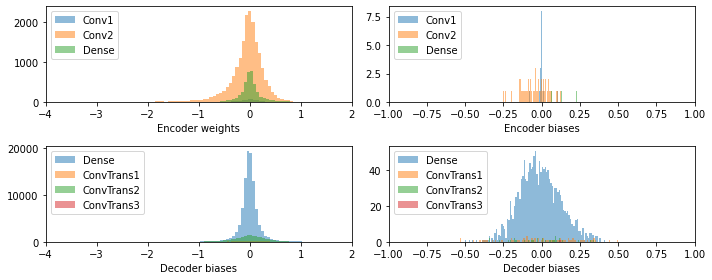

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

model = MultiSplit(16, 4, (14,14,1), (56,56,1))
model.encoder.load_weights('../weights/42_CAE4x16_enc_epoch50_weights.h5')
model.decoder.load_weights('../weights/42_CAE4x16_dec_epoch50_weights.h5')

w1 = model.encoder.layers[0].get_weights()[0].flatten()
b1 = model.encoder.layers[0].get_weights()[1].flatten()

w2 = model.encoder.layers[1].get_weights()[0].flatten()
b2 = model.encoder.layers[1].get_weights()[1].flatten()

w3 = model.encoder.layers[3].get_weights()[0].flatten()
b3 = model.encoder.layers[3].get_weights()[1].flatten()

# 0,2,3,4
decoder_w1 = model.decoder.layers[0].get_weights()[0].flatten()
decoder_b1 = model.decoder.layers[0].get_weights()[1].flatten()

decoder_w2 = model.decoder.layers[2].get_weights()[0].flatten()
decoder_b2 = model.decoder.layers[2].get_weights()[1].flatten()

decoder_w3 = model.decoder.layers[3].get_weights()[0].flatten()
decoder_b3 = model.decoder.layers[3].get_weights()[1].flatten()

decoder_w4 = model.decoder.layers[4].get_weights()[0].flatten()
decoder_b4 = model.decoder.layers[4].get_weights()[1].flatten()

plt.figure(figsize=(10, 4))

ax1 = plt.subplot(2,2,1)
plt.hist(w1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(w2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(w3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Encoder weights')
plt.xlim((-4,2))
plt.legend(['Conv1', 'Conv2', 'Dense'], loc='upper left')

ax2 = plt.subplot(2,2,2)
# plt.hist(b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(decoder_b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Encoder biases')
plt.xlim((-1,1))
plt.legend(['Conv1', 'Conv2', 'Dense'], loc='upper left')

ax3 = plt.subplot(2,2,3, sharex=ax1)
plt.hist(decoder_w1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_w2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_w3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_w4, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(decoder_w_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Decoder biases')
plt.legend(['Dense', 'ConvTrans1', 'ConvTrans2', 'ConvTrans3'], loc='upper left')

ax4 = plt.subplot(2,2,4, sharex=ax2)
# plt.hist(b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(decoder_b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_b1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_b2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_b3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(decoder_b4, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Decoder biases')
plt.legend(['Dense', 'ConvTrans1', 'ConvTrans2', 'ConvTrans3'], loc='upper left')
plt.tight_layout()

plt.savefig('../img/53_PLOTS/decoder_weights.png',  bbox_inches='tight', transparent=False, pad_inches=0.1)

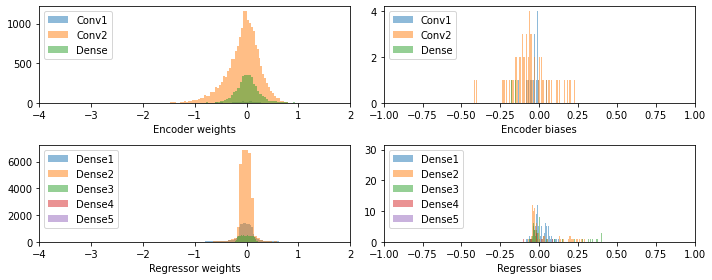

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

model = MultiSplit(16, 4, (14,14,1), (56,56,1))
model.encoder.load_weights('../weights/42_CAE4x16_regr_enc_epoch50_weights.h5')
model.regressor.load_weights('../weights/42_CAE4x16_regr_regr_epoch50_weights.h5')

w1 = model.encoder.layers[0].get_weights()[0].flatten()
b1 = model.encoder.layers[0].get_weights()[1].flatten()

w2 = model.encoder.layers[1].get_weights()[0].flatten()
b2 = model.encoder.layers[1].get_weights()[1].flatten()

w3 = model.encoder.layers[3].get_weights()[0].flatten()
b3 = model.encoder.layers[3].get_weights()[1].flatten()

regr_w1 = model.regressor.layers[0].get_weights()[0].flatten()
regr_b1 = model.regressor.layers[0].get_weights()[1].flatten()

regr_w2 = model.regressor.layers[1].get_weights()[0].flatten()
regr_b2 = model.regressor.layers[1].get_weights()[1].flatten()

regr_w3 = model.regressor.layers[2].get_weights()[0].flatten()
regr_b3 = model.regressor.layers[2].get_weights()[1].flatten()

regr_w4 = model.regressor.layers[3].get_weights()[0].flatten()
regr_b4 = model.regressor.layers[3].get_weights()[1].flatten()

regr_w5 = model.regressor.layers[4].get_weights()[0].flatten()
regr_b5 = model.regressor.layers[4].get_weights()[1].flatten()

w_ges = np.concatenate((w1,w2,w3), axis=0)
b_ges = np.concatenate((b1,b2,b3), axis=0)

regr_w_ges = np.concatenate((regr_w1,regr_w2,regr_w3, regr_w4), axis=0)
regr_b_ges = np.concatenate((regr_b1,regr_b2,regr_b3, regr_b4), axis=0)

plt.figure(figsize=(10, 4))

ax1 = plt.subplot(2,2,1)
plt.hist(w1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(w2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(w3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlim((-4,2))
plt.xlabel('Encoder weights')
plt.legend(['Conv1', 'Conv2', 'Dense'], loc='upper left')

ax2 = plt.subplot(2,2,2)
# plt.hist(b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(regr_b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(b3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlim((-1,1))
plt.xlabel('Encoder biases')
plt.legend(['Conv1', 'Conv2', 'Dense'], loc='upper left')

ax3 = plt.subplot(2,2,3, sharex=ax1)
plt.hist(regr_w1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_w2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_w3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_w4, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_w5, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(regr_w_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Regressor weights')
plt.legend(['Dense1', 'Dense2', 'Dense3', 'Dense4', 'Dense5'], loc='upper left')

ax4 = plt.subplot(2,2,4, sharex=ax2)
# plt.hist(b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
# plt.hist(regr_b_ges, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_b1, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_b2, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_b3, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_b4, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.hist(regr_b5, density=False, bins=100, alpha=0.5)  # density=False would make counts
plt.xlabel('Regressor biases')
plt.legend(['Dense1', 'Dense2', 'Dense3', 'Dense4', 'Dense5'], loc='upper left')
plt.tight_layout()

plt.savefig('../img/53_PLOTS/regr_weights.png',  bbox_inches='tight', transparent=False, pad_inches=0.1)